In [ ]:
#all imports

import numpy as np
import matplotlib.pyplot as plt

import pickle
import networkx as nx
import igraph as ig
import scipy.sparse as sp
import os
import enum
import time 
import re
import argparse

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

# Setting Up The Dataset

In [ ]:
class DatasetType(enum.Enum):
    CORA = 0

class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1
 
end=200
CORA_TRAIN = [0, end]
CORA_VAL= [end, end+500]
CORA_TEST = [1708, 1708+1000]
CORA_FEATURES = 1433
CORA_CLASSES = 7
#  ^
#  |
# Case Based
# Genetic Algorithms
# Neural Networks
# Probabilistic Methods
# Reinforcement Learning
# Rule Learning
# Theory

In [189]:
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora')
color_map = {0: "red", 1: "skyblue", 2: "green", 3: "orange", 4: "blue", 5: "pink", 6: "black"}

In [190]:
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [191]:
def normalize(sparse):
    assert sp.issparse(sparse)
    node_features = np.array(sparse.sum(-1))  # sum features for every node feature vector
    node_features_sum = np.power(node_features, -1).squeeze()
    node_features_sum[np.isinf(node_features_sum)] = 1. #handling 1/0 divs
    diagonal_inv_features_sum_matrix = sp.diags(node_features_sum) # diagonal matrix whose values on the diag come from node_features_sum

    return diagonal_inv_features_sum_matrix.dot(sparse)

def build_edge_index(adjacency_list_dict, num_of_nodes, includeSelf=True):
    src_ids=[]
    target_ids = []
    seen_edges = set()
    for src, neighboring_nodes in adjacency_list_dict.items():
        for target in neighboring_nodes:
            if (src, target) not in seen_edges:  # removing duplicated edges
                src_ids.append(src)
                target_ids.append(target)
                seen_edges.add((src, target))
    if includeSelf:
        src_ids.extend(np.arange(num_of_nodes))
        target_ids.extend(np.arange(num_of_nodes))

    edge_index = np.row_stack((src_ids, target_ids))

    return edge_index

In [192]:
def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}


In [193]:
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        node_features_csr = normalize(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, includeSelf=True)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN[0], CORA_TRAIN[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL[0], CORA_VAL[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST[0], CORA_TEST[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')
    


node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([200]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


C:\Users\HP\AppData\Local\Temp\ipykernel_18756\194796886.py:3: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


## Visualising the Dataset

In [194]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray)

    # not needed for Cora as undirected graph but in case of social network graphs it is very important
    in_degrees = np.zeros(num_of_nodes, dtype=int)
    out_degrees = np.zeros(num_of_nodes, dtype=int)

    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1
        in_degrees[target_node_id] += 1 

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(10,8), dpi=100) 
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

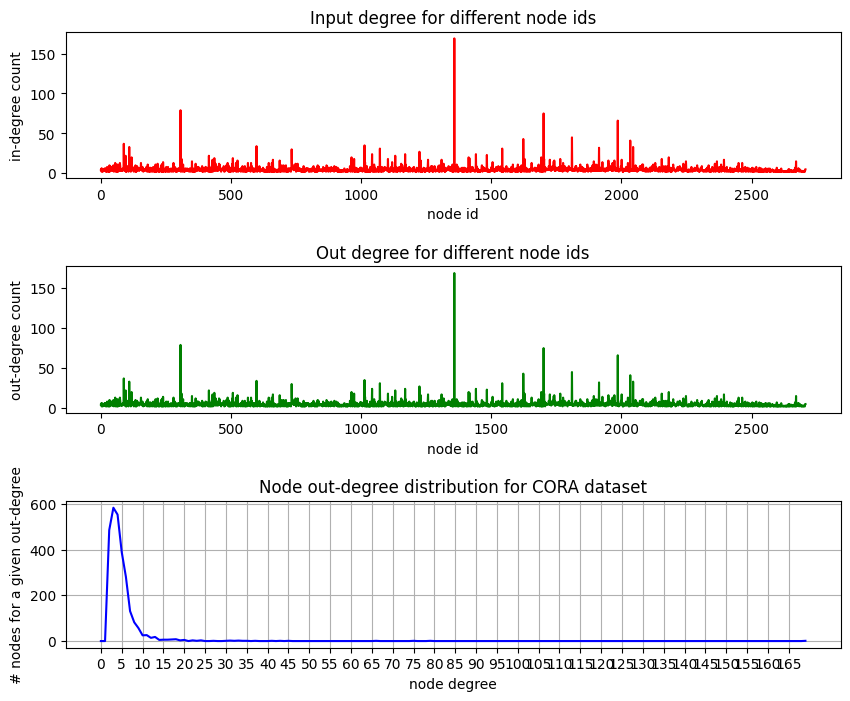

In [195]:
num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

In [196]:
dataset_name = config['dataset_name']
visualization_tool=0
if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :])) 

ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

visual_style = {}

visual_style["bbox"] = (500, 500)
visual_style["margin"] = 5

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# Cora specific (7 classes only)
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [color_map[label] for label in node_labels_np]

visual_style["layout"] = ig_graph.layout_kamada_kawai()

ig.plot(ig_graph, **visual_style)

### GAT Setup

In [ ]:
class GATLayer(torch.nn.Module):
    src_nodes_dim = 0
    trg_nodes_dim = 1
    nodes_dim = 0
    head_dim = 1 

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concat or avg
        self.add_skip_connection = add_skip_connection

        
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # taken as in the paper
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  
        self.attention_weights = None

        self.init_params()
        
    def forward(self, data):
        in_nodes_features, edge_index = data 
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2

        in_nodes_features = self.dropout(in_nodes_features)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)
        nodes_features_proj = self.dropout(nodes_features_proj) 
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        attentions_per_edge = self.dropout(attentions_per_edge)
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        size = list(exp_scores_per_edge.shape) 
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape) 
        size[self.nodes_dim] = num_of_nodes 
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights: 
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer 

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i], 
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,
                activation=nn.ELU() if i < num_of_layers - 1 else None,  
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

In [ ]:
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2
    
writer = SummaryWriter() 
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [ ]:
def get_training_state(training_config, model):
    training_state = {
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],
        "state_dict": model.state_dict()
    }

    return training_state

def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict': 
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')

def get_available_binary_name():
    prefix = 'gat'
    def valid_binary_name(binary_name):
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1 
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

In [ ]:
def get_training_args():
    parser = argparse.ArgumentParser()

    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture
    gat_config = {
        "num_of_layers": 2,
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [CORA_FEATURES, 8, CORA_CLASSES],
        "add_skip_connection": False, 
        "bias": True,  
        "dropout": 0.6, 
    }

    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    training_config.update(gat_config)

    return training_config

In [202]:
trainingLog=[]

def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0 

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    graph_data = (node_features, edge_index)  

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase) 

        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)
        
        if phase == LoopPhase.TRAIN:
            trainAcc=main_loop(phase=LoopPhase.TEST)
            trainingLog.append(trainAcc)
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')
                

            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC) 
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0  
            else:
                PATIENCE_CNT += 1 

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy

    return main_loop  

In [203]:
def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False).to(device)

    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS= [0, 0] 

    for epoch in range(config['num_of_epochs']):
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e: 
                print(str(e))
                break

    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1

    # torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))
    torch.save({
    'model_state_dict': gat.state_dict(),
    'config': config
}, "gat_cora_full_model.pt")

### GAT Training

In [204]:
train_gat(get_training_args())

C:\Users\HP\AppData\Local\Temp\ipykernel_18756\194796886.py:3: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


GAT training: time elapsed= 0.06 [s] | epoch=1 | val acc=0.308
GAT training: time elapsed= 4.79 [s] | epoch=101 | val acc=0.7
GAT training: time elapsed= 9.33 [s] | epoch=201 | val acc=0.792
GAT training: time elapsed= 13.82 [s] | epoch=301 | val acc=0.806
GAT training: time elapsed= 18.33 [s] | epoch=401 | val acc=0.798
GAT training: time elapsed= 22.30 [s] | epoch=501 | val acc=0.818
GAT training: time elapsed= 26.29 [s] | epoch=601 | val acc=0.812
GAT training: time elapsed= 30.27 [s] | epoch=701 | val acc=0.824
GAT training: time elapsed= 34.27 [s] | epoch=801 | val acc=0.828
GAT training: time elapsed= 38.29 [s] | epoch=901 | val acc=0.814
GAT training: time elapsed= 42.44 [s] | epoch=1001 | val acc=0.826
GAT training: time elapsed= 46.78 [s] | epoch=1101 | val acc=0.836
GAT training: time elapsed= 50.98 [s] | epoch=1201 | val acc=0.834
GAT training: time elapsed= 55.20 [s] | epoch=1301 | val acc=0.822
GAT training: time elapsed= 59.53 [s] | epoch=1401 | val acc=0.828
GAT training

[0.318, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.319, 0.32, 0.321, 0.322, 0.322, 0.324, 0.33, 0.34, 0.357, 0.374, 0.383, 0.393, 0.398, 0.407, 0.411, 0.416, 0.418, 0.422, 0.426, 0.431, 0.43, 0.439, 0.442, 0.429, 0.41, 0.397, 0.393, 0.391, 0.395, 0.397, 0.404, 0.415, 0.428, 0.442, 0.459, 0.488, 0.519, 0.53, 0.537, 0.544, 0.552, 0.556, 0.56, 0.562, 0.569, 0.571, 0.572, 0.576, 0.576, 0.581, 0.591, 0.602, 0.607, 0.606, 0.608, 0.604, 0.595, 0.594, 0.594, 0.593, 0.585, 0.595, 0.603, 0.629, 0.638, 0.648, 0.659, 0.679, 0.693, 0.7, 0.707, 0.721, 0.733, 0.741, 0.747, 0.75, 0.757, 0.757, 0.753, 0.739, 0.721, 0.705, 0.691, 0.676, 0.675, 0.675, 0.68, 0.695, 0.71, 0.718, 0.723, 0.726, 0.741, 0.752, 0.762, 0.784, 0.799, 0.796, 0.796, 0.787, 0.789, 0.781, 0.776, 0.768, 0.768, 0.757, 0.753, 0.745, 0.75, 0.756, 0.764, 0.773, 0.781, 0.785, 0.794, 0.802, 0.808, 0.812, 0.81, 0.802, 0.801, 0.802, 0.798, 0.794, 0.793, 0.791

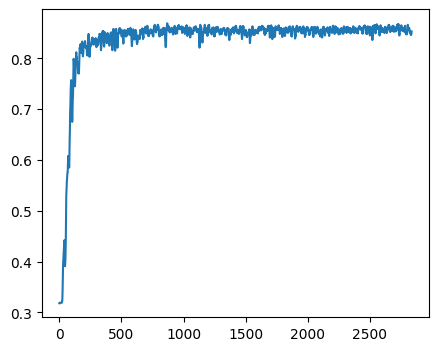

In [205]:
print(trainingLog)
plt.figure(figsize=(5,4))
plt.plot(trainingLog)
plt.show()

In [206]:
def gat_forward_pass(model_name, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path)

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate all the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat

In [207]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

In [208]:
from sklearn.manifold import TSNE
from scipy.stats import entropy


# Let's define an enum as a clean way to pick between different visualization options
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,


def visualize_gat_properties(model_name=r'gat_000000.pth', dataset_name=DatasetType.CORA.name, visualization_type=VisualizationType.ATTENTION):
    
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)
    
    if visualization_type == VisualizationType.EMBEDDINGS:  # visualize embeddings (using t-SNE)
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels))

        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=80)
        for class_id in range(num_classes):
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=color_map[class_id], edgecolors='black', linewidths=0.2)
        plt.show()

    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        for layer_id in range(num_layers):
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                for target_node_id in range(num_of_nodes):  # find every the neighborhood for every node in the graph
        
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
        
                    ideal_uniform_attention = np.ones(len(neigborhood_attention))/len(neigborhood_attention)

                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Cora entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='orange', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='dodgerblue')

                fig = plt.gcf() 
                plt.show()
                fig.savefig(os.path.join(DATA_DIR_PATH, f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')


***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.822
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************



C:\Users\HP\AppData\Local\Temp\ipykernel_18756\194796886.py:3: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


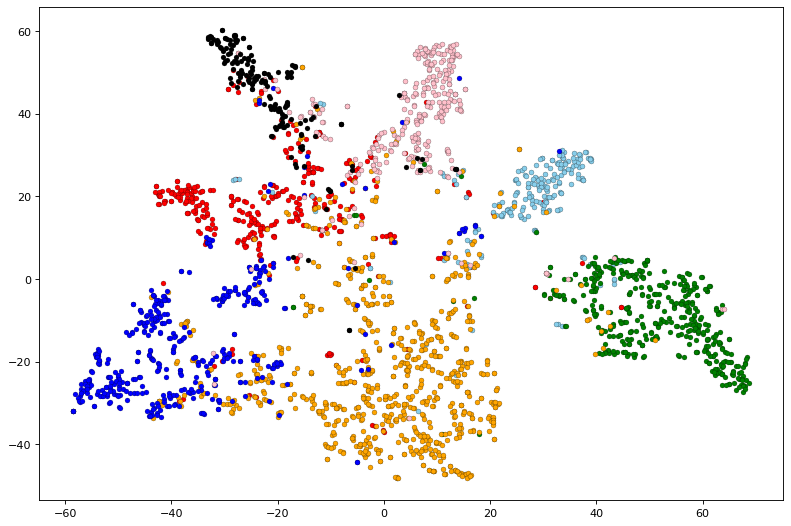

In [209]:
model_name=r'gat_000000.pth' 
dataset_name=DatasetType.CORA.name


visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)


***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.822
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************

Highest degree nodes = [1986 1701  306 1358]
Max attention weight = 0.013214568607509136 and min = 0.012319730594754219


C:\Users\HP\AppData\Local\Temp\ipykernel_18756\194796886.py:3: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


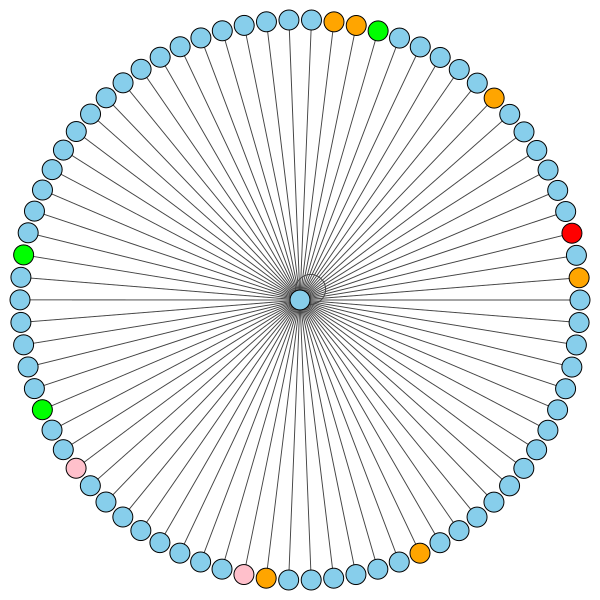

In [ ]:
all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)

num_nodes_of_interest = 4 
head_to_visualize = 0  
gat_layer_id = 1  

total_num_of_nodes = len(node_features)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes) 
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :])) 
complete_graph.add_edges(edge_index_tuples)

highest_degree_node_ids = np.argpartition(complete_graph.degree(), -num_nodes_of_interest)[-num_nodes_of_interest:]
random_node_ids = np.random.randint(low=0, high=total_num_of_nodes, size=num_nodes_of_interest)

print(f'Highest degree nodes = {highest_degree_node_ids}')
      
target_node_ids = edge_index[1]
source_nodes = edge_index[0]

target_node_id = 306

src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
size_of_neighborhood = len(source_node_ids)

labels = node_labels[source_node_ids].cpu().numpy()

all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()

print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights) 

id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

visual_style = {
    "edge_width": attention_weights,
    "layout": ig_graph.layout_reingold_tilford_circular() 
}

if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [color_map[label] for label in labels]
else:
    print('Add custom color scheme for your specific dataset. Using igraph default coloring.')

ig.plot(ig_graph, **visual_style)

C:\Users\HP\AppData\Local\Temp\ipykernel_18756\194796886.py:3: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)



***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.822
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************



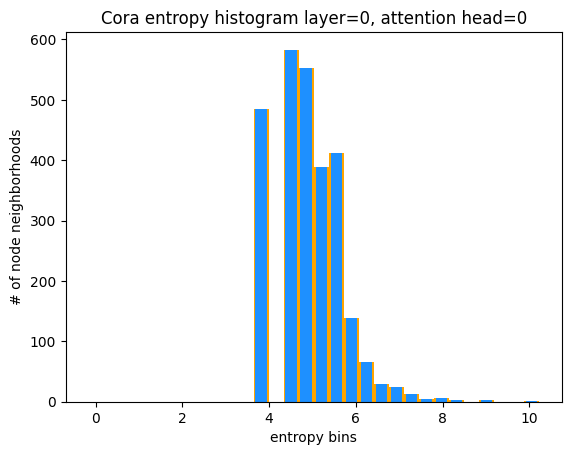

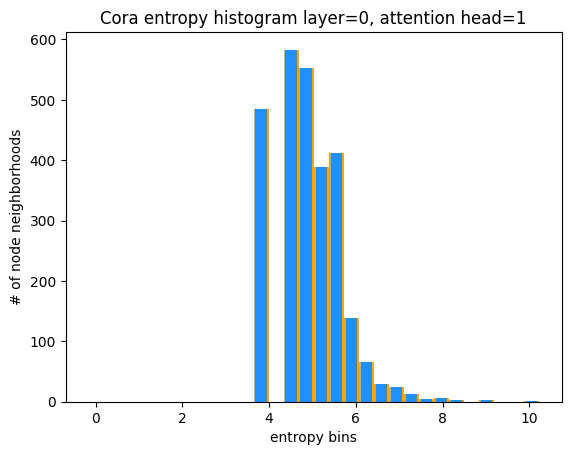

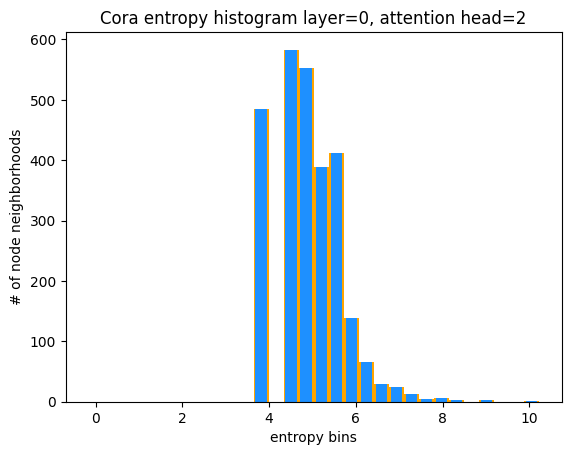

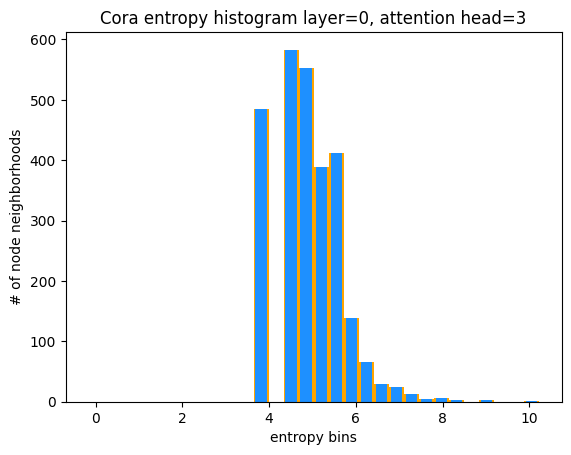

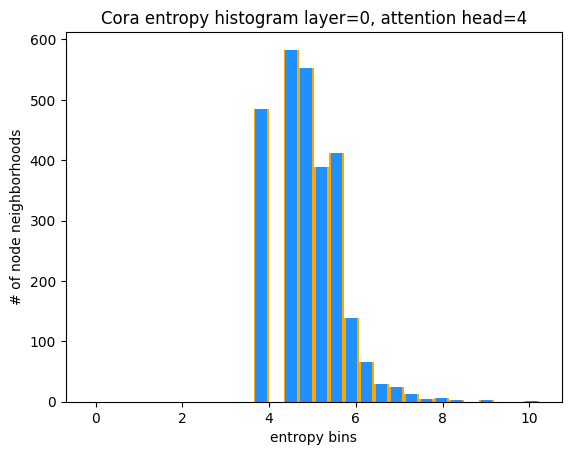

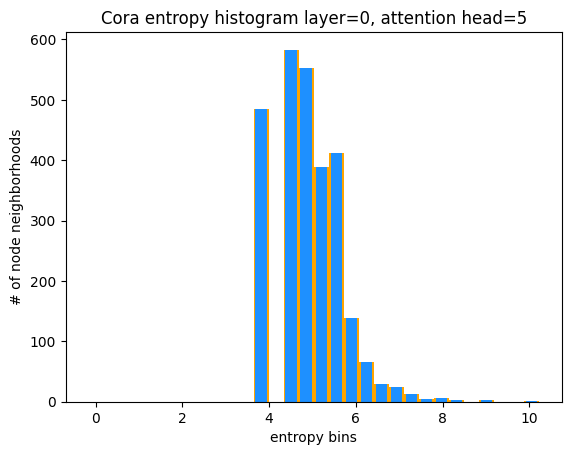

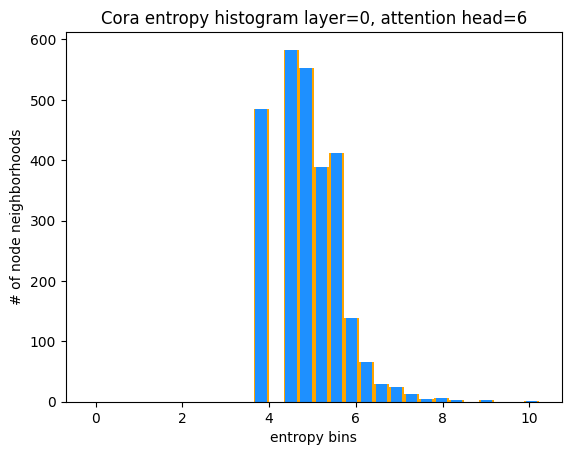

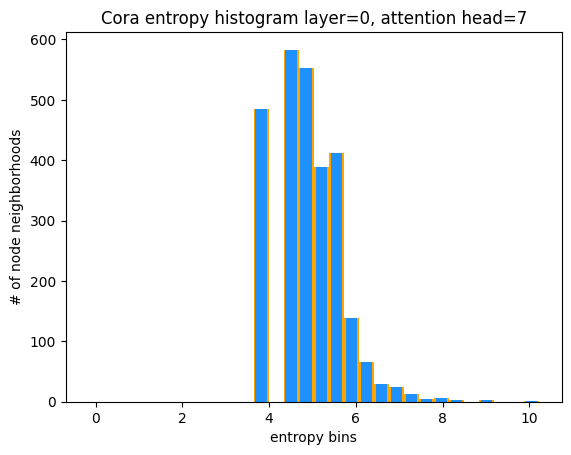

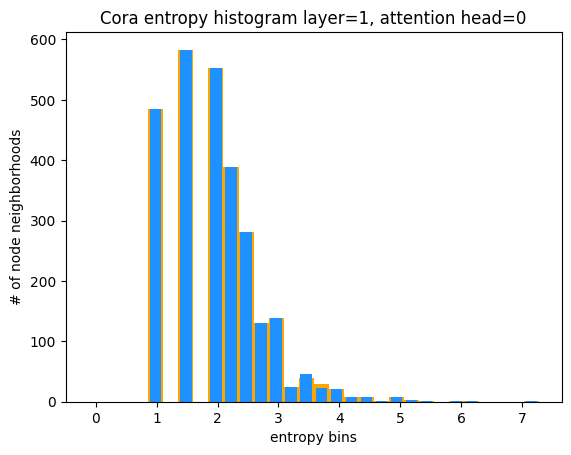

In [211]:
visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.ENTROPY 
)